In [ ]:
# 1. Upgrade pip to avoid any old-pip quirks
!pip install --upgrade pip

# 2. Dynamically grab your PyTorch & CUDA versions
import torch

# strips off any “+cuXXX” suffix from the torch version
def format_torch_version(v):
    return v.split('+')[0]

TORCH = format_torch_version(torch.__version__)
CUDA  = 'cu' + torch.version.cuda.replace('.', '')

print(f"Installing for torch {TORCH} on {CUDA}…")

# 3. Install the core PyG C++/CUDA extensions from pre-built wheels
!pip install torch-scatter   -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse    -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster   -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html

# 4. Now install PyTorch Geometric and the temporal extension
!pip install torch-geometric
!pip install torch-geometric-temporal


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Installing for torch 2.6.0 on cu124…
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 57.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 30.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 46.6 MB/s eta 0:00:00
   

In [ ]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.nn import GCNConv

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCNConv(node_features,32)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

In [ ]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

100%|██████████| 200/200 [01:06<00:00,  3.00it/s]


MSE: 0.9988


In [ ]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = TGCN(node_features, 32)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h

model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    cost = 0
    hidden_state = None
    for time, snapshot in enumerate(train_dataset):
        y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,hidden_state)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

model.eval()
cost = 0
hidden_state = None
for time, snapshot in enumerate(test_dataset):
    y_hat, hidden_state = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, hidden_state)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


MSE: 1.0085


In [ ]:
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, MeanAggregator

# 1) Load data WITHOUT hand-crafted lags (use lag=1 so x is the current value)
loader = ChickenpoxDatasetLoader()
dataset = loader.get_dataset(lags=1)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

# 2) Build TGN memory and prediction head
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_nodes = dataset.features[0].shape[0]
raw_msg_dim = 1       # single feature per node per timestep
tmemory_dim = 32
time_dim   = 32

memory = TGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=raw_msg_dim,
    memory_dim=tmemory_dim,
    time_dim=time_dim,
    message_module=IdentityMessage(raw_msg_dim, tmemory_dim, time_dim),
    aggregator_module=MeanAggregator()
).to(device)

predictor = torch.nn.Linear(tmemory_dim, 1).to(device)

# Optimizer, scheduler, and loss
optimizer = Adam(list(memory.parameters()) + list(predictor.parameters()), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
loss_fn = torch.nn.MSELoss()

# 3) Training loop with memory reset and detachment at each step
dmemory = memory
dpredictor = predictor

dmemory.train()
dpredictor.train()
for epoch in tqdm(range(50)):
    dmemory.reset_state()   # clear memory at start of epoch
    total_loss = 0.0

    for t_step, snapshot in enumerate(train_dataset):
        dmemory.detach()  # prevent retaining old graph

        # Prepare data\ن# Ensure features are single-dim per node
        x = snapshot.x.to(device)
        y = snapshot.y.to(device)
        src = torch.arange(num_nodes, device=device)
        dst = src.clone()
        raw_msg = x
        t = torch.full((num_nodes,), t_step, dtype=torch.long, device=device)

        # Forward and backward
        optimizer.zero_grad()
        dmemory.update_state(src, dst, t, raw_msg)
        h, _ = dmemory(src)
        y_hat = dpredictor(h).squeeze()
        loss = loss_fn(y_hat, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(memory.parameters()) + list(predictor.parameters()), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataset.features)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1:03d}, Loss: {avg_loss:.4f}")

# 4) Evaluation on test split
dmemory.eval()
dpredictor.eval()
total_loss = 0.0
with torch.no_grad():
    dmemory.reset_state()
    for t_step, snapshot in enumerate(test_dataset):
        dmemory.detach()
        x = snapshot.x.to(device)
        y = snapshot.y.to(device)
        src = torch.arange(num_nodes, device=device)
        dst = src.clone()
        raw_msg = x
        t = torch.full((num_nodes,), t_step, dtype=torch.long, device=device)

        dmemory.update_state(src, dst, t, raw_msg)
        h, _ = dmemory(src)
        y_hat = dpredictor(h).squeeze()
        total_loss += loss_fn(y_hat, y).item()

    mse = total_loss / len(test_dataset.features)
    print(f"Test MSE: {mse:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  2%|▏         | 1/50 [00:01<01:18,  1.60s/it]

Epoch 001, Loss: 0.8375


  4%|▍         | 2/50 [00:02<01:02,  1.30s/it]

Epoch 002, Loss: 0.7203


  6%|▌         | 3/50 [00:03<00:53,  1.15s/it]

Epoch 003, Loss: 0.6726


  8%|▊         | 4/50 [00:04<00:50,  1.10s/it]

Epoch 004, Loss: 0.6501


 10%|█         | 5/50 [00:05<00:44,  1.01it/s]

Epoch 005, Loss: 0.6333


 12%|█▏        | 6/50 [00:06<00:39,  1.12it/s]

Epoch 006, Loss: 0.6268


 14%|█▍        | 7/50 [00:06<00:36,  1.18it/s]

Epoch 007, Loss: 0.6225


 16%|█▌        | 8/50 [00:07<00:33,  1.26it/s]

Epoch 008, Loss: 0.6239


 18%|█▊        | 9/50 [00:08<00:31,  1.29it/s]

Epoch 009, Loss: 0.6288


 20%|██        | 10/50 [00:09<00:30,  1.32it/s]

Epoch 010, Loss: 0.6347


 22%|██▏       | 11/50 [00:09<00:28,  1.36it/s]

Epoch 011, Loss: 0.6377


 24%|██▍       | 12/50 [00:10<00:27,  1.38it/s]

Epoch 012, Loss: 0.6403


 26%|██▌       | 13/50 [00:11<00:26,  1.39it/s]

Epoch 013, Loss: 0.6466


 28%|██▊       | 14/50 [00:11<00:25,  1.40it/s]

Epoch 014, Loss: 0.6452


 30%|███       | 15/50 [00:12<00:24,  1.41it/s]

Epoch 015, Loss: 0.6393


 32%|███▏      | 16/50 [00:13<00:23,  1.42it/s]

Epoch 016, Loss: 0.6314


 34%|███▍      | 17/50 [00:13<00:23,  1.43it/s]

Epoch 017, Loss: 0.6260


 36%|███▌      | 18/50 [00:14<00:22,  1.42it/s]

Epoch 018, Loss: 0.6222


 38%|███▊      | 19/50 [00:15<00:23,  1.30it/s]

Epoch 019, Loss: 0.6197


 40%|████      | 20/50 [00:16<00:24,  1.22it/s]

Epoch 020, Loss: 0.6180


 42%|████▏     | 21/50 [00:17<00:25,  1.12it/s]

Epoch 021, Loss: 0.6165


 44%|████▍     | 22/50 [00:18<00:23,  1.19it/s]

Epoch 022, Loss: 0.6152


 46%|████▌     | 23/50 [00:19<00:21,  1.24it/s]

Epoch 023, Loss: 0.6139


 48%|████▊     | 24/50 [00:19<00:20,  1.28it/s]

Epoch 024, Loss: 0.6125


 50%|█████     | 25/50 [00:20<00:19,  1.30it/s]

Epoch 025, Loss: 0.6113


 52%|█████▏    | 26/50 [00:21<00:17,  1.34it/s]

Epoch 026, Loss: 0.6104


 54%|█████▍    | 27/50 [00:21<00:16,  1.38it/s]

Epoch 027, Loss: 0.6099


 56%|█████▌    | 28/50 [00:22<00:15,  1.39it/s]

Epoch 028, Loss: 0.6096


 58%|█████▊    | 29/50 [00:23<00:14,  1.41it/s]

Epoch 029, Loss: 0.6090


 60%|██████    | 30/50 [00:23<00:14,  1.41it/s]

Epoch 030, Loss: 0.6083


 62%|██████▏   | 31/50 [00:24<00:13,  1.41it/s]

Epoch 031, Loss: 0.6074


 64%|██████▍   | 32/50 [00:25<00:12,  1.40it/s]

Epoch 032, Loss: 0.6064


 66%|██████▌   | 33/50 [00:26<00:12,  1.40it/s]

Epoch 033, Loss: 0.6054


 68%|██████▊   | 34/50 [00:26<00:11,  1.40it/s]

Epoch 034, Loss: 0.6043


 70%|███████   | 35/50 [00:27<00:10,  1.42it/s]

Epoch 035, Loss: 0.6032


 72%|███████▏  | 36/50 [00:28<00:11,  1.26it/s]

Epoch 036, Loss: 0.6020


 74%|███████▍  | 37/50 [00:29<00:10,  1.18it/s]

Epoch 037, Loss: 0.6008


 76%|███████▌  | 38/50 [00:30<00:10,  1.14it/s]

Epoch 038, Loss: 0.5997


 78%|███████▊  | 39/50 [00:31<00:09,  1.22it/s]

Epoch 039, Loss: 0.5984


 80%|████████  | 40/50 [00:31<00:07,  1.28it/s]

Epoch 040, Loss: 0.5970


 82%|████████▏ | 41/50 [00:32<00:06,  1.33it/s]

Epoch 041, Loss: 0.5954


 84%|████████▍ | 42/50 [00:33<00:05,  1.37it/s]

Epoch 042, Loss: 0.5935


 86%|████████▌ | 43/50 [00:33<00:04,  1.40it/s]

Epoch 043, Loss: 0.5915


 88%|████████▊ | 44/50 [00:34<00:04,  1.41it/s]

Epoch 044, Loss: 0.5895


 90%|█████████ | 45/50 [00:35<00:03,  1.40it/s]

Epoch 045, Loss: 0.5876


 92%|█████████▏| 46/50 [00:35<00:02,  1.42it/s]

Epoch 046, Loss: 0.5859


 94%|█████████▍| 47/50 [00:36<00:02,  1.42it/s]

Epoch 047, Loss: 0.5844


 96%|█████████▌| 48/50 [00:37<00:01,  1.42it/s]

Epoch 048, Loss: 0.5828


 98%|█████████▊| 49/50 [00:38<00:00,  1.42it/s]

Epoch 049, Loss: 0.5815


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]

Epoch 050, Loss: 0.5803


Test MSE: 0.7725


In [ ]:
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, MeanAggregator

# Set number of lags for lagged features
lags = 4  # use last 4 weeks of data as features

# 1) Load data WITH lagged features
loader = ChickenpoxDatasetLoader()
dataset = loader.get_dataset(lags=lags)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# 2) Build TGN memory and prediction head
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_nodes = dataset.features[0].shape[0]
raw_msg_dim = lags         # now each node's message is a vector of length 'lags'
tmemory_dim = 32
time_dim   = 32

memory = TGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=raw_msg_dim,
    memory_dim=tmemory_dim,
    time_dim=time_dim,
    message_module=IdentityMessage(raw_msg_dim, tmemory_dim, time_dim),
    aggregator_module=MeanAggregator()
).to(device)

predictor = torch.nn.Linear(tmemory_dim, 1).to(device)

# Optimizer, scheduler, and loss
optimizer = Adam(list(memory.parameters()) + list(predictor.parameters()), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
loss_fn = torch.nn.MSELoss()

# Early stopping params
best_val = float('inf')
patience = 10
wait = 0

# 3) Training loop with validation and early stopping
dmemory = memory
dpredictor = predictor
dmemory.train()
dpredictor.train()
for epoch in tqdm(range(200), desc='Epoch'):
    # Reset memory and training loss
    dmemory.reset_state()
    train_loss = 0.0

    # Training
    for t_step, snapshot in enumerate(train_dataset):
        dmemory.detach()
        x = snapshot.x.to(device)   # shape [num_nodes, lags]
        y = snapshot.y.to(device)
        src = torch.arange(num_nodes, device=device)
        raw_msg = x
        t = torch.full((num_nodes,), t_step, dtype=torch.long, device=device)

        optimizer.zero_grad()
        dmemory.update_state(src, src, t, raw_msg)
        h, _ = dmemory(src)
        y_hat = dpredictor(h).squeeze()
        loss = loss_fn(y_hat, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(memory.parameters()) + list(predictor.parameters()), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    avg_train = train_loss / len(train_dataset.features)

    # Validation
    dmemory.eval()
    val_loss = 0.0
    with torch.no_grad():
        dmemory.reset_state()
        for t_step, snapshot in enumerate(test_dataset):
            dmemory.detach()
            x = snapshot.x.to(device)
            y = snapshot.y.to(device)
            src = torch.arange(num_nodes, device=device)
            raw_msg = x
            t = torch.full((num_nodes,), t_step, dtype=torch.long, device=device)

            dmemory.update_state(src, src, t, raw_msg)
            h, _ = dmemory(src)
            y_hat = dpredictor(h).squeeze()
            val_loss += loss_fn(y_hat, y).item()
    avg_val = val_loss / len(test_dataset.features)

    # Scheduler and early stopping
    scheduler.step(avg_val)
    print(f"Epoch {epoch+1:03d} | Train: {avg_train:.4f} | Val: {avg_val:.4f}")
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save({'model': dpredictor.state_dict(), 'memory': dmemory.state_dict()}, 'best_checkpoint.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    dmemory.train()
    dpredictor.train()

# 4) Load best model and evaluate on test
checkpoint = torch.load('best_checkpoint.pth')
predictor.load_state_dict(checkpoint['model'])
memory.load_state_dict(checkpoint['memory'])
memory.eval()
predictor.eval()

total_loss = 0.0
with torch.no_grad():
    memory.reset_state()
    for t_step, snapshot in enumerate(test_dataset):
        memory.detach()
        x = snapshot.x.to(device)
        y = snapshot.y.to(device)
        src = torch.arange(num_nodes, device=device)
        raw_msg = x
        t = torch.full((num_nodes,), t_step, dtype=torch.long, device=device)

        memory.update_state(src, src, t, raw_msg)
        h, _ = memory(src)
        y_hat = predictor(h).squeeze()
        total_loss += loss_fn(y_hat, y).item()
    mse = total_loss / len(test_dataset.features)
    print(f"Test MSE: {mse:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch:   0%|          | 1/200 [00:03<10:20,  3.12s/it]

Epoch 001 | Train: 0.8194 | Val: 0.8100


Epoch:   1%|          | 2/200 [00:06<10:07,  3.07s/it]

Epoch 002 | Train: 0.6950 | Val: 0.7531


Epoch:   2%|▏         | 3/200 [00:12<15:32,  4.73s/it]

Epoch 003 | Train: 0.6778 | Val: 0.7395


Epoch:   2%|▏         | 4/200 [00:15<13:20,  4.08s/it]

Epoch 004 | Train: 0.6668 | Val: 0.7250


Epoch:   2%|▎         | 5/200 [00:18<12:03,  3.71s/it]

Epoch 005 | Train: 0.6560 | Val: 0.7095


Epoch:   3%|▎         | 6/200 [00:22<11:48,  3.65s/it]

Epoch 006 | Train: 0.6520 | Val: 0.7027


Epoch:   4%|▎         | 7/200 [00:25<11:27,  3.56s/it]

Epoch 007 | Train: 0.6499 | Val: 0.7044


Epoch:   4%|▍         | 8/200 [00:28<10:53,  3.40s/it]

Epoch 008 | Train: 0.6486 | Val: 0.7064


Epoch:   4%|▍         | 9/200 [00:32<10:29,  3.30s/it]

Epoch 009 | Train: 0.6477 | Val: 0.7087


Epoch:   5%|▌         | 10/200 [00:35<10:43,  3.39s/it]

Epoch 010 | Train: 0.6482 | Val: 0.7004


Epoch:   6%|▌         | 11/200 [00:38<10:38,  3.38s/it]

Epoch 011 | Train: 0.6419 | Val: 0.6936


Epoch:   6%|▌         | 12/200 [00:42<10:17,  3.28s/it]

Epoch 012 | Train: 0.6353 | Val: 0.6936


Epoch:   6%|▋         | 13/200 [00:45<10:00,  3.21s/it]

Epoch 013 | Train: 0.6329 | Val: 0.6940


Epoch:   7%|▋         | 14/200 [00:48<10:32,  3.40s/it]

Epoch 014 | Train: 0.6329 | Val: 0.6989


Epoch:   8%|▊         | 15/200 [00:52<10:10,  3.30s/it]

Epoch 015 | Train: 0.6346 | Val: 0.7057


Epoch:   8%|▊         | 16/200 [00:55<09:51,  3.21s/it]

Epoch 016 | Train: 0.6391 | Val: 0.6982


Epoch:   8%|▊         | 17/200 [00:58<09:37,  3.16s/it]

Epoch 017 | Train: 0.6359 | Val: 0.7035


Epoch:   9%|▉         | 18/200 [01:01<10:12,  3.36s/it]

Epoch 018 | Train: 0.6289 | Val: 0.7051


Epoch:  10%|▉         | 19/200 [01:04<09:50,  3.26s/it]

Epoch 019 | Train: 0.6232 | Val: 0.7066


Epoch:  10%|█         | 20/200 [01:08<09:39,  3.22s/it]

Epoch 020 | Train: 0.6215 | Val: 0.7087


Epoch:  10%|█         | 20/200 [01:11<10:39,  3.55s/it]

Epoch 021 | Train: 0.6201 | Val: 0.7108
Early stopping at epoch 21


Test MSE: 0.6936


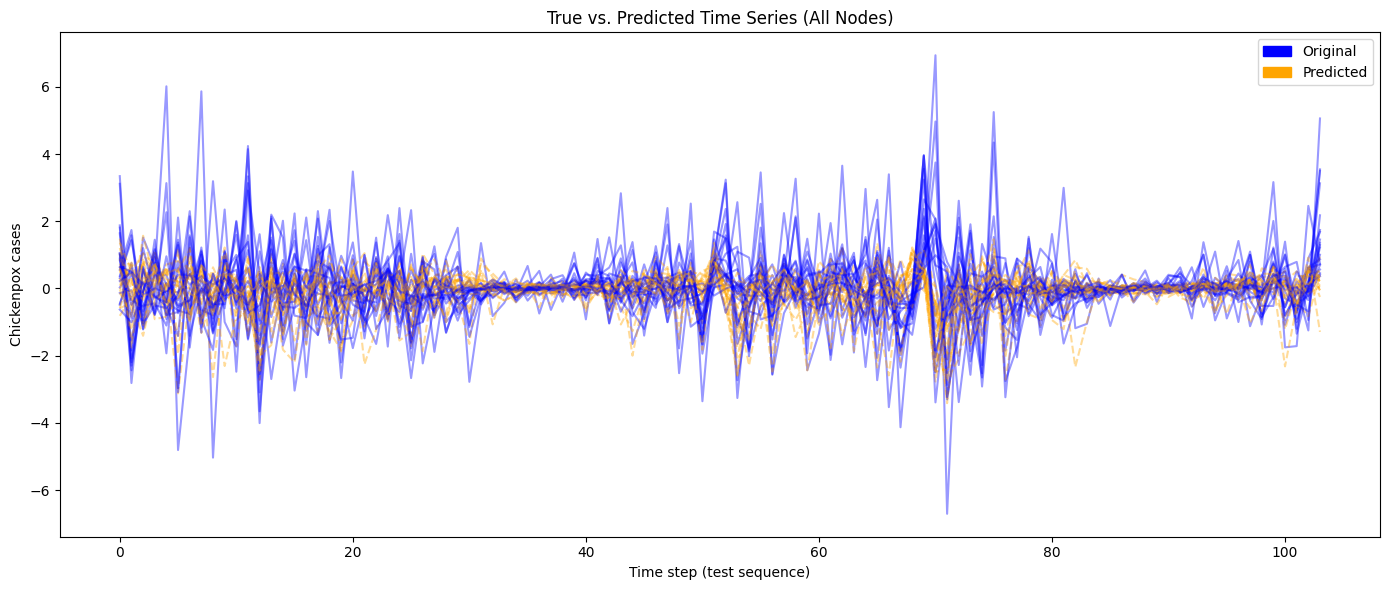

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, MeanAggregator

# 1) Parameters (must match your training setup)
lags       = 4
tmemory_dim = 32
time_dim    = 32

# 2) Load dataset and split
loader = ChickenpoxDatasetLoader()
dataset = loader.get_dataset(lags=lags)
_, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)
num_nodes = dataset.features[0].shape[0]

# 3) Rebuild model & load checkpoint
memory = TGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=lags,
    memory_dim=tmemory_dim,
    time_dim=time_dim,
    message_module=IdentityMessage(lags, tmemory_dim, time_dim),
    aggregator_module=MeanAggregator()
)
predictor = torch.nn.Linear(tmemory_dim, 1)

ckpt = torch.load('best_checkpoint.pth', map_location='cpu')
memory.load_state_dict(ckpt['memory'])
predictor.load_state_dict(ckpt['model'])

memory.eval()

# 4) Collect true & predicted for test sequence
y_true_list = []
y_pred_list = []

with torch.no_grad():
    memory.reset_state()
    for t_step, snapshot in enumerate(test_dataset):
        memory.detach()

        x = snapshot.x           # shape [N, lags]
        y = snapshot.y.numpy()   # shape [N]

        src = torch.arange(num_nodes)
        t   = torch.full((num_nodes,), t_step, dtype=torch.long)

        # update memory & get embeddings
        memory.update_state(src, src, t, x)
        h, _ = memory(src)
        y_hat = predictor(h).squeeze().numpy()

        y_true_list.append(y)
        y_pred_list.append(y_hat)

# Convert to arrays: [T_test, N]
y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

plt.figure(figsize=(14, 6))
timesteps = np.arange(y_true.shape[0])

# Plot each node’s series
for node in range(num_nodes):
    plt.plot(timesteps, y_true[:, node], color='blue',  alpha=0.4)
    plt.plot(timesteps, y_pred[:, node], color='orange', linestyle='--', alpha=0.4)

# Create a simple legend
import matplotlib.patches as mpatches
orig_patch = mpatches.Patch(color='blue',   label='Original')
pred_patch = mpatches.Patch(color='orange', label='Predicted')
plt.legend(handles=[orig_patch, pred_patch], loc='upper right')

plt.xlabel('Time step (test sequence)')
plt.ylabel('Chickenpox cases')
plt.title('True vs. Predicted Time Series (All Nodes)')
plt.tight_layout()
plt.show()



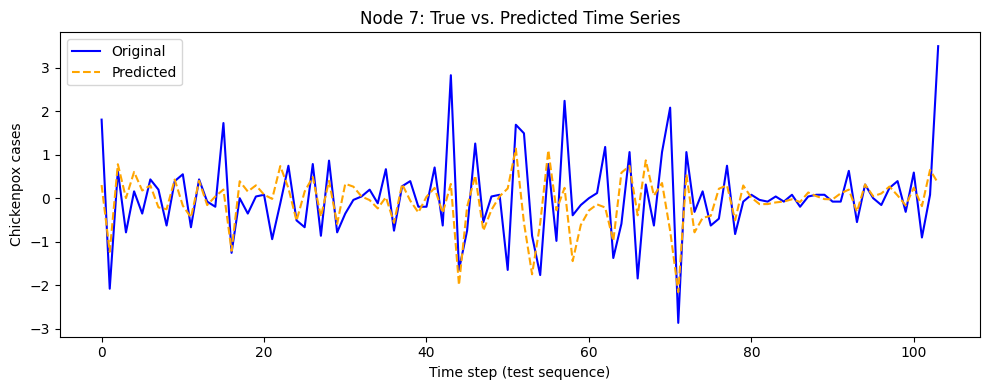

In [ ]:
# 1) Select a random node index
node = np.random.randint(0, y_true.shape[1])

# 2) Extract its series
true_series = y_true[:, node]
pred_series = y_pred[:, node]
timesteps   = np.arange(true_series.shape[0])

# 3) Plot
plt.figure(figsize=(10, 4))
plt.plot(timesteps, true_series, color='blue', label='Original')
plt.plot(timesteps, pred_series, color='orange', linestyle='--', label='Predicted')

plt.xlabel('Time step (test sequence)')
plt.ylabel('Chickenpox cases')
plt.title(f'Node {node}: True vs. Predicted Time Series')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, MeanAggregator

# 1) Load data and build event stream

def load_data():
    loader = ChickenpoxDatasetLoader()
    dataset = loader.get_dataset(lags=1)
    train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)
    num_nodes = dataset.features[0].shape[0]
    return train_dataset, test_dataset, num_nodes


def build_event_stream(dataset_split, num_nodes, device):
    """
    Convert snapshots into a streaming list of node-update events on specified device.
    """
    events = []
    labels = [snap.y.squeeze() for snap in dataset_split]
    labels.append(torch.zeros_like(labels[0]))
    for t_step, snap in enumerate(dataset_split):
        x = snap.x.squeeze().to(device)
        y_next = labels[t_step + 1].to(device)
        for node_id in range(num_nodes):
            raw_msg = x[node_id].unsqueeze(0)    # [1]
            label   = y_next[node_id].unsqueeze(0) # [1]
            events.append({
                'src':     torch.tensor([node_id], dtype=torch.long, device=device),
                'dst':     torch.tensor([node_id], dtype=torch.long, device=device),
                't':       torch.tensor([t_step],   dtype=torch.long, device=device),
                'raw_msg': raw_msg.unsqueeze(0),       # [1,1]
                'label':   label                       # [1]
            })
    return events

# Prepare data and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset, test_dataset, num_nodes = load_data()
train_events = build_event_stream(train_dataset, num_nodes, device)
test_events  = build_event_stream(test_dataset, num_nodes, device)

# 2) Initialize model on GPU
dumemory = TGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=1,
    memory_dim=32,
    time_dim=32,
    message_module=IdentityMessage(1, 32, 32),
    aggregator_module=MeanAggregator()
).to(device)
# Ensure last_update buffer is on GPU
dumemory.last_update = dumemory.last_update.to(device)
predictor = torch.nn.Linear(32, 1).to(device)

# Optimizer, scheduler, loss
optimizer = Adam(list(dumemory.parameters()) + list(predictor.parameters()), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = torch.nn.MSELoss()

epochs = 50
for epoch in range(epochs := epochs if False else epochs):
    dumemory.reset_state()
    dumemory.train()
    predictor.train()
    total_loss = 0.0

    for ev in train_events:
        dumemory.detach()  # truncate graph for streaming

        # Unpack event
        src, dst, t = ev['src'], ev['dst'], ev['t']
        raw_msg = ev['raw_msg'].to(device)  # [1, raw_msg_dim]
        label   = ev['label'].to(device)    # [1]

        # Update memory and predict
        dumemory.update_state(src, dst, t, raw_msg)
        h, _ = dumemory(src)                # [1, memory_dim]
        y_hat = predictor(h).squeeze(-1)    # [1]

        # Loss and optimization
        loss = loss_fn(y_hat, label)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(dumemory.parameters()) + list(predictor.parameters()), max_norm=1.0
        )
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_events)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1:03d}, Streaming Loss: {avg_loss:.4f}")

# 3) Evaluation on GPU
dumemory.reset_state()
dumemory.eval()
predictor.eval()
total_loss = 0.0
with torch.no_grad():
    for ev in test_events:
        src, dst, t = ev['src'], ev['dst'], ev['t']
        raw_msg = ev['raw_msg'].to(device)
        label   = ev['label'].to(device)

        dumemory.update_state(src, dst, t, raw_msg)
        h, _ = dumemory(src)
        y_hat = predictor(h).squeeze(-1)
        total_loss += loss_fn(y_hat, label).item()

    mse = total_loss / len(test_events)
    print(f"Streaming Test MSE: {mse:.4f}")

Epoch 001, Streaming Loss: 0.9042
Epoch 002, Streaming Loss: 0.8879
Epoch 003, Streaming Loss: 0.8855
Epoch 004, Streaming Loss: 0.8820
Epoch 005, Streaming Loss: 0.8808
Epoch 006, Streaming Loss: 0.8783
Epoch 007, Streaming Loss: 0.8770
Epoch 008, Streaming Loss: 0.8748
Epoch 009, Streaming Loss: 0.8728
Epoch 010, Streaming Loss: 0.8687
Epoch 011, Streaming Loss: 0.8678
Epoch 012, Streaming Loss: 0.8654
Epoch 013, Streaming Loss: 0.8659
Epoch 014, Streaming Loss: 0.8667
Epoch 015, Streaming Loss: 0.8839
Epoch 016, Streaming Loss: 0.8851
Epoch 017, Streaming Loss: 0.8821
Epoch 018, Streaming Loss: 0.8734
Epoch 019, Streaming Loss: 0.8638
Epoch 020, Streaming Loss: 0.8583
Epoch 021, Streaming Loss: 0.8525
Epoch 022, Streaming Loss: 0.8489
Epoch 023, Streaming Loss: 0.8458
Epoch 024, Streaming Loss: 0.8451
Epoch 025, Streaming Loss: 0.8435
Epoch 026, Streaming Loss: 0.8485
Epoch 027, Streaming Loss: 0.8408
Epoch 028, Streaming Loss: 0.8457
Epoch 029, Streaming Loss: 0.8306
Epoch 030, Str

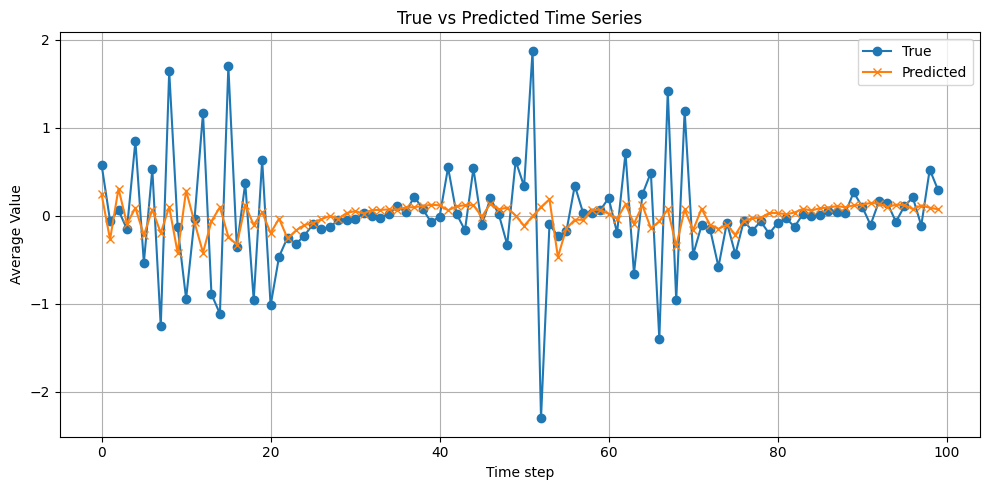

In [ ]:
import matplotlib.pyplot as plt

times, y_trues, y_preds = [], [], []

with torch.no_grad():
    dumemory.reset_state()
    dumemory.eval()
    predictor.eval()
    for ev in test_events[:2000]:
        src, dst, t = ev['src'], ev['dst'], ev['t']
        raw_msg = ev['raw_msg']
        label   = ev['label']

        dumemory.update_state(src, dst, t, raw_msg)
        h, _ = dumemory(src)
        y_hat = predictor(h).squeeze(-1)

        # record
        times.append(t.item())
        y_trues.append(label.item())
        y_preds.append(y_hat.item())

# 3) Aggregate per timestamp (e.g. average over nodes at each t)
time_dict = {}
for tt, yt, yp in zip(times, y_trues, y_preds):
    time_dict.setdefault(tt, {'true': [], 'pred': []})
    time_dict[tt]['true'].append(yt)
    time_dict[tt]['pred'].append(yp)

sorted_times = sorted(time_dict)
avg_true = [sum(time_dict[t]['true'])/len(time_dict[t]['true']) for t in sorted_times]
avg_pred = [sum(time_dict[t]['pred'])/len(time_dict[t]['pred']) for t in sorted_times]

# 4) Plot
plt.figure(figsize=(10,5))
plt.plot(sorted_times, avg_true, marker='o', label='True')
plt.plot(sorted_times, avg_pred, marker='x', label='Predicted')
plt.xlabel('Time step')
plt.ylabel('Average Value')
plt.title('True vs Predicted Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, MeanAggregator
import matplotlib.pyplot as plt

# 1) Load data and build event stream, predicting deltas
def load_data():
    loader = ChickenpoxDatasetLoader()
    dataset = loader.get_dataset(lags=1)
    train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)
    num_nodes = dataset.features[0].shape[0]
    return train_dataset, test_dataset, num_nodes


def build_event_stream_delta(dataset_split, num_nodes, device):
    """
    Convert snapshots into a streaming list of node-update events,
    with labels as delta = x_{t+1} - x_t.
    """
    events = []
    values = [snap.x.squeeze() for snap in dataset_split]
    next_vals = values[1:] + [torch.zeros_like(values[0])]
    for t_step, (x, y_next) in enumerate(zip(values, next_vals)):
        x = x.to(device)
        y_next = y_next.to(device)
        for node_id in range(num_nodes):
            # x_t is last observed value
            x_t = x[node_id].unsqueeze(0)        # shape [1]
            delta = (y_next[node_id] - x_t).unsqueeze(0)  # shape [1,1]
            events.append({
                'src':     torch.tensor([node_id], dtype=torch.long, device=device),
                'dst':     torch.tensor([node_id], dtype=torch.long, device=device),
                't':       torch.tensor([t_step],   dtype=torch.long, device=device),
                'raw_msg': x_t.unsqueeze(0),        # shape [1,1]
                'label':   delta                    # shape [1,1]
            })
    return events

# Prepare data and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset, test_dataset, num_nodes = load_data()
train_events = build_event_stream_delta(train_dataset, num_nodes, device)
test_events  = build_event_stream_delta(test_dataset, num_nodes, device)

# 2) Initialize model on GPU
dumemory = TGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=1,
    memory_dim=32,
    time_dim=32,
    message_module=IdentityMessage(1, 32, 32),
    aggregator_module=MeanAggregator()
).to(device)
dumemory.last_update = dumemory.last_update.to(device)
predictor = torch.nn.Linear(32, 1).to(device)

# Optimizer, scheduler, loss
optimizer = Adam(list(dumemory.parameters()) + list(predictor.parameters()), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = torch.nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    dumemory.reset_state()
    dumemory.train()
    predictor.train()
    total_loss = 0.0

    for ev in train_events:
        dumemory.detach()
        src, dst, t = ev['src'], ev['dst'], ev['t']
        raw_msg = ev['raw_msg']  # shape [1,1]
        label = ev['label']      # shape [1,1]

        dumemory.update_state(src, dst, t, raw_msg)
        h, _ = dumemory(src)
        delta_hat = predictor(h)      # shape [1,1]

        # Align shapes to scalar
        delta_hat = delta_hat.squeeze()
        label = label.squeeze()

        loss = loss_fn(delta_hat, label)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(dumemory.parameters()) + list(predictor.parameters()), max_norm=1.0
        )
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_events)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1:03d}, Streaming Delta Loss: {avg_loss:.4f}")

Streaming Test MSE (absolute): 1.0171


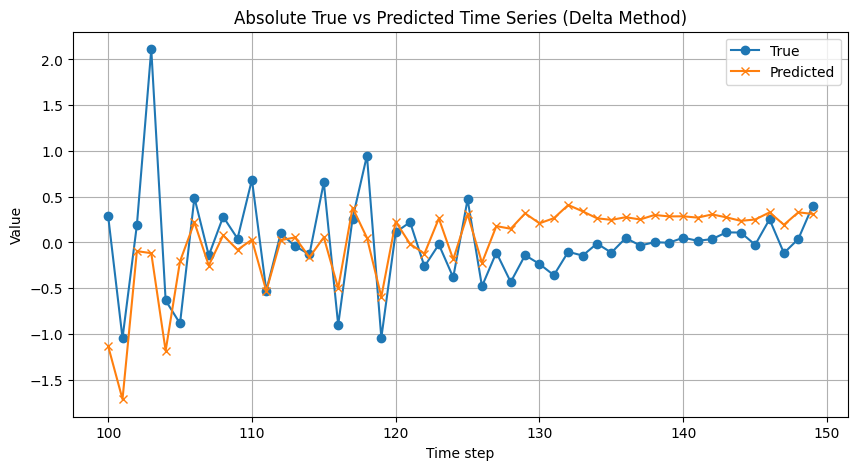

In [ ]:
# 3) Evaluation on GPU with recording absolute predictions
dumemory.reset_state()
dumemory.eval()
predictor.eval()
times, y_trues, y_preds = [], [], []
with torch.no_grad():
    for ev in test_events[2000:3000]:
        src, dst, t = ev['src'], ev['dst'], ev['t']
        raw_msg = ev['raw_msg']    # [1,1]
        label = ev['label']        # [1,1]

        dumemory.update_state(src, dst, t, raw_msg)
        h, _ = dumemory(src)
        delta_hat = predictor(h)   # [1,1]

        # Align shapes
        delta_hat = delta_hat.squeeze()
        delta_true = label.squeeze()

        # Compute absolute values
        x_t = raw_msg.squeeze().item()
        y_true = x_t + delta_true.item()
        y_pred = x_t + delta_hat.item()

        times.append(t.item())
        y_trues.append(y_true)
        y_preds.append(y_pred)

    mse = torch.tensor(y_preds).sub(torch.tensor(y_trues)).pow(2).mean().item()
    print(f"Streaming Test MSE (absolute): {mse:.4f}")

# Plot resulting absolute series
time_dict = {}
for tt, yt, yp in zip(times, y_trues, y_preds):
    time_dict.setdefault(tt, {'true': [], 'pred': []})
    time_dict[tt]['true'].append(yt)
    time_dict[tt]['pred'].append(yp)

sorted_times = sorted(time_dict.keys())
avg_true = [sum(time_dict[t]['true'])/len(time_dict[t]['true']) for t in sorted_times]
avg_pred = [sum(time_dict[t]['pred'])/len(time_dict[t]['pred']) for t in sorted_times]

plt.figure(figsize=(10,5))
plt.plot(sorted_times, avg_true, marker='o', label='True')
plt.plot(sorted_times, avg_pred, marker='x', label='Predicted')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Absolute True vs Predicted Time Series (Delta Method)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, MeanAggregator
import matplotlib.pyplot as plt

# 1) Load data and build normalized event stream

def load_data():
    loader = ChickenpoxDatasetLoader()
    dataset = loader.get_dataset(lags=1)
    train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)
    num_nodes = dataset.features[0].shape[0]
    return train_dataset, test_dataset, num_nodes


def compute_normalization(train_dataset, num_nodes, device):
    """
    Compute mean and std over all raw values and targets for z-score normalization.
    """
    xs, ys = [], []
    values = [snap.x.squeeze() for snap in train_dataset]
    next_vals = values[1:] + [torch.zeros_like(values[0])]
    for x, y_next in zip(values, next_vals):
        x = x.to(device)
        y_next = y_next.to(device)
        for node_id in range(num_nodes):
            xs.append(x[node_id].item())
            ys.append(y_next[node_id].item())
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    mean_x, std_x = xs.mean(), xs.std()
    mean_y, std_y = ys.mean(), ys.std()
    return mean_x, std_x, mean_y, std_y


def build_event_stream_norm(dataset_split, num_nodes, device, mean_x, std_x, mean_y, std_y):
    """
    Build events with z-score normalized raw_msg and label.
    raw_msg = (x_t - mean_x) / std_x
    label   = (y_{t+1} - mean_y) / std_y
    """
    events = []
    values = [snap.x.squeeze() for snap in dataset_split]
    next_vals = values[1:] + [torch.zeros_like(values[0])]
    for t_step, (x, y_next) in enumerate(zip(values, next_vals)):
        x = x.to(device)
        y_next = y_next.to(device)
        for node_id in range(num_nodes):
            x_t = x[node_id]
            y_t1 = y_next[node_id]
            raw_msg = ((x_t - mean_x) / std_x).unsqueeze(0)
            label = ((y_t1 - mean_y) / std_y).unsqueeze(0)
            events.append({
                'src':     torch.tensor([node_id], dtype=torch.long, device=device),
                'dst':     torch.tensor([node_id], dtype=torch.long, device=device),
                't':       torch.tensor([t_step],   dtype=torch.long, device=device),
                'raw_msg': raw_msg.unsqueeze(0),  # [1,1]
                'label':   label                  # [1]
            })
    return events

# Prepare data and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset, test_dataset, num_nodes = load_data()
mean_x, std_x, mean_y, std_y = compute_normalization(train_dataset, num_nodes, device)
train_events = build_event_stream_norm(train_dataset, num_nodes, device, mean_x, std_x, mean_y, std_y)
test_events  = build_event_stream_norm(test_dataset,  num_nodes, device, mean_x, std_x, mean_y, std_y)

# 2) Initialize model on GPU
dumemory = TGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=1,
    memory_dim=32,
    time_dim=32,
    message_module=IdentityMessage(1, 32, 32),
    aggregator_module=MeanAggregator()
).to(device)
dumemory.last_update = dumemory.last_update.to(device)
predictor = torch.nn.Linear(32, 1).to(device)

# Optimizer, scheduler, loss
optimizer = Adam(list(dumemory.parameters()) + list(predictor.parameters()), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = torch.nn.MSELoss()

epochs = 100
for epoch in range(epochs if False else epochs):
    dumemory.reset_state()
    dumemory.train()
    predictor.train()
    total_loss = 0.0
    for ev in train_events:
        dumemory.detach()
        src, dst, t = ev['src'], ev['dst'], ev['t']
        raw_msg = ev['raw_msg']    # normalized x_t
        label_norm = ev['label']   # [1]

        dumemory.update_state(src, dst, t, raw_msg)
        h, _ = dumemory(src)
        y_hat_norm = predictor(h).squeeze()  # scalar
        label_norm = label_norm.squeeze()    # scalar

        loss = loss_fn(y_hat_norm, label_norm)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(dumemory.parameters()) + list(predictor.parameters()), max_norm=1.0
        )
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(train_events)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1:03d}, Normalized Loss: {avg_loss:.4f}")

Streaming Test MSE (denorm): 0.9205


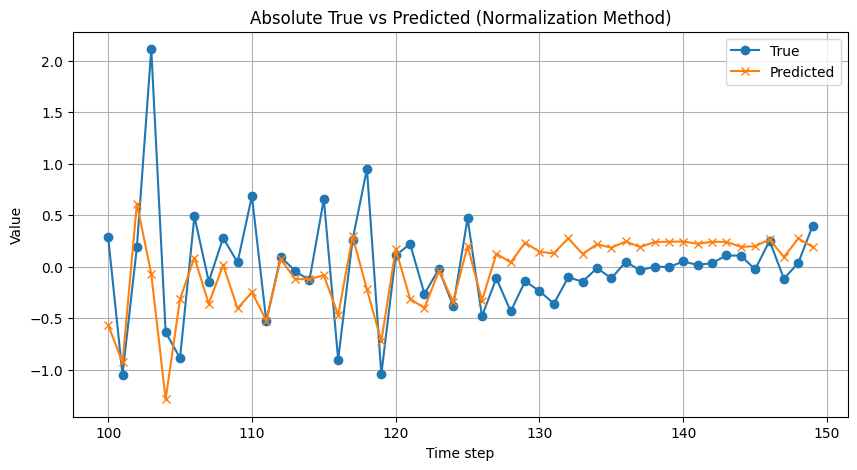

In [ ]:
# 3) Evaluation on GPU with denormalization
dumemory.reset_state()
dumemory.eval()
predictor.eval()
times, y_trues, y_preds = [], [], []
with torch.no_grad():
    for ev in test_events[2000:3000]:
        src, dst, t = ev['src'], ev['dst'], ev['t']
        raw_msg = ev['raw_msg']
        label_norm = ev['label']

        dumemory.update_state(src, dst, t, raw_msg)
        h, _ = dumemory(src)
        y_hat_norm = predictor(h).squeeze()

        # denormalize
        x_t_norm = raw_msg.squeeze().item()
        x_t = x_t_norm * std_x.item() + mean_x.item()
        y_hat = y_hat_norm.item() * std_y.item() + mean_y.item()
        y_true = label_norm.squeeze().item() * std_y.item() + mean_y.item()

        times.append(t.item())
        y_trues.append(y_true)
        y_preds.append(y_hat)

    mse = torch.tensor(y_preds).sub(torch.tensor(y_trues)).pow(2).mean().item()
    print(f"Streaming Test MSE (denorm): {mse:.4f}")

# 4) Plot absolute series
time_dict = {}
for tt, yt, yp in zip(times, y_trues, y_preds):
    time_dict.setdefault(tt, {'true': [], 'pred': []})
    time_dict[tt]['true'].append(yt)
    time_dict[tt]['pred'].append(yp)
sorted_times = sorted(time_dict.keys())
avg_true = [sum(time_dict[t]['true'])/len(time_dict[t]['true']) for t in sorted_times]
avg_pred = [sum(time_dict[t]['pred'])/len(time_dict[t]['pred']) for t in sorted_times]
plt.figure(figsize=(10,5))
plt.plot(sorted_times, avg_true, marker='o', label='True')
plt.plot(sorted_times, avg_pred, marker='x', label='Predicted')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Absolute True vs Predicted (Normalization Method)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!unzip graphs_for_corvic.zip

In [ ]:
import json
from torch_geometric.data import Data

dir = "graphs_for_corvic"
with open(f'{dir}/1980.json','r') as f:
    data = json.load(f)
    nodes = data['nodes']
    links = data['links']

In [ ]:
enc_nodes = {}
nodes_labels = {}
for i,node in enumerate(nodes):
    enc_nodes[node['id']] = i
    nodes_labels[node['id']] = node['node_type']

In [ ]:
import json
import torch
from torch_geometric.data import Data

def form_graph(year):
    dir = "graphs_for_corvic"
    with open(f'{dir}/{year}.json', 'r') as f:
        data = json.load(f)
        nodes = data['nodes']
        links = data['links']

    edges = []
    edge_attr = []
    for x in links:
        i = enc_nodes[x['source']]
        j = enc_nodes[x['target']]
        edges.append([i, j])
        edge_attr.append([x['weight']])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr  = torch.tensor(edge_attr, dtype=torch.float)

    graph = Data(edge_index=edge_index, edge_attr=edge_attr)

    return graph


In [ ]:
snapshots = []
for year in range(1980,1990):
  graph = form_graph(year)
  snapshots.append(graph)

In [ ]:
import random
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn.models.tgn import (
    TGNMemory,
    IdentityMessage,
    MeanAggregator,
    TimeEncoder,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ──────────────────────────────────────────────────────────────────────────────
# 0)  NODE-INDUCED SUBGRAPH SAMPLER (with relabelling)
# ──────────────────────────────────────────────────────────────────────────────
def induced_subgraph(snapshots, M=10_000, seed=42):
    rng = random.Random(seed)
    node_pool = set()
    for g in snapshots:
        node_pool.update(g.edge_index.flatten().tolist())
    chosen_old = set(rng.sample(list(node_pool), min(M, len(node_pool))))
    old2new = {old: idx for idx, old in enumerate(sorted(chosen_old))}

    sampled = []
    for g in snapshots:
        src, dst = g.edge_index
        mask = torch.tensor(
            [(u.item() in chosen_old) and (v.item() in chosen_old)
             for u, v in zip(src, dst)],
            dtype=torch.bool
        )
        if mask.any():
            idxs = mask.nonzero(as_tuple=False).view(-1)
            src_new = torch.tensor([old2new[src[i].item()] for i in idxs], dtype=torch.long)
            dst_new = torch.tensor([old2new[dst[i].item()] for i in idxs], dtype=torch.long)
            sampled.append(Data(
                edge_index=torch.stack([src_new, dst_new], dim=0),
                edge_attr=g.edge_attr[idxs]
            ))
        else:
            sampled.append(Data(
                edge_index=torch.empty(2, 0, dtype=torch.long),
                edge_attr=torch.empty(0, 1)
            ))
    return sampled, len(chosen_old)

# ──────────────────────────────────────────────────────────────────────────────
# 1)  EVENT BUILDER
# ──────────────────────────────────────────────────────────────────────────────
def events_from_snapshots(snapshots):
    events, nxt_maps = [], []
    for g in snapshots[1:]:
        nxt_maps.append({(u.item(), v.item()): w.item()
                         for (u, v), w in zip(g.edge_index.t(), g.edge_attr)})
    for t, (g_cur, nxt_dict) in enumerate(zip(snapshots[:-1], nxt_maps)):
        for (u, v), w in zip(g_cur.edge_index.t(), g_cur.edge_attr):
            u, v = u.item(), v.item()
            events.append({
                "src":     torch.tensor([u], dtype=torch.long, device=device),
                "dst":     torch.tensor([v], dtype=torch.long, device=device),
                "t":       torch.tensor([t], dtype=torch.long, device=device),
                "raw_msg": w.view(1, 1).to(device),
                "label":   torch.tensor([nxt_dict.get((u, v), 0.0)],
                                        dtype=torch.float, device=device)
            })
    num_nodes = int(torch.cat([g.edge_index for g in snapshots], dim=1).max()) + 1
    return events, num_nodes

# ──────────────────────────────────────────────────────────────────────────────
# 2)  BATCH UTILS
# ──────────────────────────────────────────────────────────────────────────────
def batch_events_by_year(events):
    buckets = defaultdict(list)
    for idx, ev in enumerate(events):
        t = int(ev["t"].item())
        buckets[t].append(idx)
    return [buckets[t] for t in sorted(buckets)]

# ──────────────────────────────────────────────────────────────────────────────
# 3)  EDGE-REGRESSION HEAD
# ──────────────────────────────────────────────────────────────────────────────
class EdgePredictor(torch.nn.Module):
    def __init__(self, mem_dim=64):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * mem_dim, mem_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(mem_dim, 1)
        )
    def forward(self, h_src, h_dst):
        return self.mlp(torch.cat([h_src, h_dst], dim=-1)).squeeze()

# ──────────────────────────────────────────────────────────────────────────────
# 4)  TRAIN WITH YEARLY VECTORISED BATCHES + TIME ENCODING
# ──────────────────────────────────────────────────────────────────────────────
def train_tgn(snapshots, num_nodes, mem_dim=64, epochs=10, lr=1e-3):
    events, _     = events_from_snapshots(snapshots)
    year_batches  = batch_events_by_year(events)

    # Time encoder for relative timestamps
    time_dim = mem_dim
    time_enc = TimeEncoder(time_dim).to(device)

    # raw_msg_dim now includes time_dim
    raw_msg_dim = 1 + time_dim
    memory = TGNMemory(
        num_nodes=num_nodes,
        raw_msg_dim=raw_msg_dim,
        memory_dim=mem_dim,
        time_dim=time_dim,
        message_module=IdentityMessage(raw_msg_dim, mem_dim, time_dim),
        aggregator_module=MeanAggregator()
    ).to(device)

    predictor = EdgePredictor(mem_dim).to(device)
    optimizer = torch.optim.Adam(
        list(memory.parameters()) + list(predictor.parameters()),
        lr=lr
    )
    loss_fn   = torch.nn.MSELoss()

    for epoch in range(1, epochs + 1):
        memory.reset_state()
        total_loss = 0.0
        total_edges = 0

        for batch in year_batches:
            # Batch vectors
            srcs   = torch.cat([events[i]["src"]    for i in batch]).view(-1).to(device)
            dsts   = torch.cat([events[i]["dst"]    for i in batch]).view(-1).to(device)
            ts     = torch.cat([events[i]["t"]      for i in batch]).view(-1).to(device)
            msgs   = torch.cat([events[i]["raw_msg"] for i in batch]).view(-1, 1).to(device)
            labels = torch.cat([events[i]["label"]   for i in batch]).view(-1).to(device)

            # Compute relative time and encode
            last_upd = memory.last_update[srcs]
            rel_t    = (ts.to(torch.float) - last_upd.to(torch.float)).view(-1, 1)
            t_enc    = time_enc(rel_t)
            msgs_time = torch.cat([msgs, t_enc], dim=-1)

            memory.detach()
            memory.update_state(srcs, dsts, ts, msgs_time)

            h_src, _ = memory(srcs)
            h_dst, _ = memory(dsts)
            y_hat    = predictor(h_src, h_dst)
            loss     = loss_fn(y_hat, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bs = labels.size(0)
            total_loss += loss.item() * bs
            total_edges += bs

        print(f"Epoch {epoch:02d} | train-MSE: {total_loss/total_edges:.4f}")
    return memory, predictor, time_enc

# ──────────────────────────────────────────────────────────────────────────────
# 5)  EVALUATE + PLOT (with time encoding)
# ──────────────────────────────────────────────────────────────────────────────
def evaluate_and_plot(snapshots, memory, predictor, time_enc, sample_k=5):
    memory.reset_state()
    events, _ = events_from_snapshots(snapshots)

    with torch.no_grad():
        for ev in events:
            src = ev["src"]
            dst = ev["dst"]
            t   = ev["t"]
            msg = ev["raw_msg"]

            last_upd = memory.last_update[src]
            rel_t    = (t.to(torch.float) - last_upd.to(torch.float)).view(-1, 1)
            t_enc    = time_enc(rel_t)
            msg_time = torch.cat([msg.view(-1,1), t_enc], dim=-1)

            memory.update_state(src, dst, t, msg_time)

        # Rest is unchanged
        g_last   = snapshots[-1]
        src, dst = g_last.edge_index
        h_src, _ = memory(src.to(device))
        h_dst, _ = memory(dst.to(device))
        y_pred   = predictor(h_src, h_dst)
        mse_val  = torch.nn.functional.mse_loss(
            y_pred, g_last.edge_attr.to(device)
        ).item()
        print(f"\nMSE on final year (sampled subgraph): {mse_val:.4f}")

        edges  = list(zip(src.tolist(), dst.tolist()))
        chosen = random.sample(range(len(edges)), k=min(sample_k, len(edges)))
        plt.figure(figsize=(9,4))
        for idx in chosen:
            u,v = edges[idx]
            true_ts = []
            for g in snapshots:
                mp = {(a.item(), b.item()): w.item()
                      for (a,b), w in zip(g.edge_index.t(), g.edge_attr)}
                true_ts.append(mp.get((u,v), 0.0))
            pred_pt = y_pred[idx].item()
            plt.plot(range(len(snapshots)), true_ts, label=f'True {u}->{v}')
            plt.scatter(len(snapshots)-1, pred_pt, marker='x', s=80,
                        label=f'Pred {u}->{v}')
        plt.title("Sample edge-weight series")
        plt.xlabel("Year index"); plt.ylabel("Weight")
        plt.legend(); plt.grid(True); plt.show()


In [ ]:
snapshots_full = [form_graph(year) for year in range(1980,1985)]
snapshots_sub, num_nodes_sub = induced_subgraph(snapshots_full, M=1000, seed=42)
memory, predictor = train_tgn(snapshots_sub, num_nodes_sub,
                               mem_dim=64, epochs=60, lr=1e-3)

In [ ]:
evaluate_and_plot(snapshots_sub, memory, predictor, sample_k=5)

In [ ]:
from torch_geometric.nn import TGNMemory, TransformerConv
import torch
from torch.nn import Linear
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    TimeEncoder,
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class GraphAttentionEmbedding(torch.nn.Module):
    """Temporal attention layer."""

    def __init__(
        self, in_channels: int, out_channels: int, msg_dim: int, time_enc: TimeEncoder
    ):
        """Initialize temporal attention layer."""
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(
            in_channels, out_channels // 2, heads=2, dropout=0.1, edge_dim=edge_dim
        )

    def forward(self, x, last_update, edge_index, t, msg):
        """Compute node embeddings."""
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)

In [ ]:
class LinkPredictor(torch.nn.Module):
    """Compute probabilities for edges between sources and destinations."""

    def __init__(self, in_channels):
        """Initialize link predictor."""
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        """Compute edge probabilities."""
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)

In [ ]:
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, LastAggregator, TimeEncoder
from torch_geometric.nn import TransformerConv

mem_dim    = 64
time_dim   = 64
emb_dim    = 128
lr         = 1e-3
epochs     = 20

time_enc = TimeEncoder(time_dim).to(device)

memory = TGNMemory(
    num_nodes    = len(enc_nodes),
    raw_msg_dim  = 1 + time_dim,
    memory_dim   = mem_dim,
    time_dim     = time_dim,
    message_module    = IdentityMessage(1+time_dim, mem_dim, time_dim),
    aggregator_module = LastAggregator(),
).to(device)

gnn = TransformerConv(
    in_channels = mem_dim,
    out_channels= emb_dim // 2,
    heads        = 2,
    edge_dim     = 1 + time_dim,
    dropout      = 0.1,
).to(device)

predictor = torch.nn.Sequential(
    torch.nn.Linear(2*emb_dim, emb_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(emb_dim, 1),
).to(device)

opt     = torch.optim.Adam(
    list(memory.parameters()) +
    list(gnn.parameters())    +
    list(predictor.parameters()),
    lr=lr
)
loss_fn = torch.nn.MSELoss()

In [ ]:
for epoch in range(1, epochs+1):
    memory.reset_state()
    epoch_loss = 0.0
    count      = 0

    for t in range(len(snapshots)-1):
        G_cur  = snapshots[t]
        G_next = snapshots[t+1]

        srcs, dsts = G_cur.edge_index
        ws         = G_cur.edge_attr.view(-1,1)
        ts         = torch.full((srcs.size(0),), t, dtype=torch.long, device=device)

        last_upd  = memory.last_update[srcs]
        rel_t     = (ts.to(torch.float) - last_upd.to(torch.float)).view(-1,1)
        t_enc     = time_enc(rel_t)
        msgs_time = torch.cat([ws.to(device), t_enc], dim=-1)

        memory.update_state(srcs.to(device),
                            dsts.to(device),
                            ts,
                            msgs_time)

        all_nodes = torch.arange(len(enc_nodes), device=device)
        z_mem, last_upd_full = memory(all_nodes)

        z = gnn(z_mem, G_cur.edge_index.to(device), msgs_time)

        src_n, dst_n = G_next.edge_index
        h_u = z[src_n.to(device)]
        h_v = z[dst_n.to(device)]
        y_hat = predictor(torch.cat([h_u, h_v], dim=-1)).view(-1)

        y_true = G_next.edge_attr.view(-1).to(device)
        loss   = loss_fn(y_hat, y_true)

        opt.zero_grad()
        loss.backward()
        opt.step()

        memory.detach()


        epoch_loss += loss.item() * y_true.size(0)
        count      += y_true.size(0)

    print(f"Epoch {epoch:02d} | train-MSE: {epoch_loss/count:.4f}")